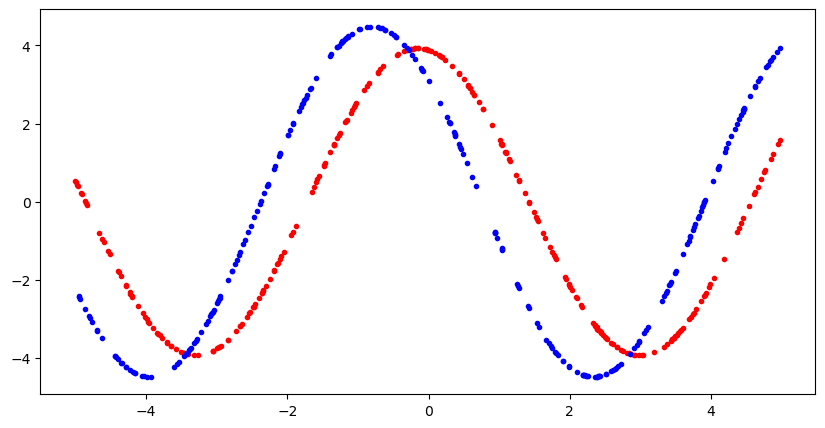

In [1]:
import jax.numpy as jnp
import numpy as np
import flax.linen as nn
import flax
from typing import Tuple, Optional, Any
import jax
import optax

def generate_sinusoids(
    batch_size: int,
    num_points: int,
    amp: Optional[float] = None,
    phase: Optional[float] = None,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Return data generated from sinusoids with a random amplitude and phase
    y = A * sin(x + phase)
    """
    if amp is not None:
        assert phase is not None
    else:
        amp = np.random.uniform(0.1, 5.0, size=(batch_size, 1, 1))
        phase = np.random.uniform(0, np.pi, size=(batch_size, 1, 1))

    samples_x = np.random.uniform(-5, 5, size=(batch_size, num_points, 1))
    samples_y = amp * np.sin(samples_x + phase)

    return samples_x, samples_y, amp, phase

def generate_sin_tasks(
    batch_size: int, num_points: int
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    x, y, _, _ = generate_sinusoids(batch_size, num_points * 2)
    meta_train_x, meta_val_x = np.split(x, 2, axis=1)
    meta_train_y, meta_val_y = np.split(y, 2, axis=1)
    return meta_train_x, meta_train_y, meta_val_x, meta_val_y

x, y, _, _ = generate_sinusoids(2, 256)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(x[0], y[0], 'r.')
plt.plot(x[1], y[1], 'b.')
plt.show()

Loss: 7.709536075592041
Loss: 0.20501738786697388
Loss: 0.07438044250011444
Loss: 0.030056891962885857
Loss: 0.01339428685605526
Loss: 0.00980442576110363
Loss: 0.005542885512113571
Loss: 0.008563527837395668
Loss: 0.0060217250138521194
Loss: 0.004051317926496267


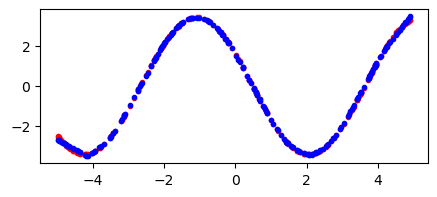

In [2]:
class Network(nn.Module):
    @nn.compact
    def __call__(self, x: np.ndarray) -> np.ndarray:
        x = nn.Dense(features=40)(x)
        x = nn.relu(x)
        x = nn.Dense(features=40)(x)
        x = nn.relu(x)
        x = nn.Dense(features=1)(x)
        return x

class TrainState(flax.struct.PyTreeNode):
    params: Any
    opt: Any = flax.struct.field(pytree_node=False)
    opt_state: Any
    module: Any = flax.struct.field(pytree_node=False)

@jax.jit
def update_fn(train_state, x, y):
    def loss_fn(grad_params):
        pred = train_state.module.apply(grad_params, x)
        return jnp.mean(jnp.square(pred - y))

    l, g = jax.value_and_grad(loss_fn)(train_state.params)
    updates, opt_state = train_state.opt.update(g, train_state.opt_state)
    params = optax.apply_updates(train_state.params, updates)
    train_state = train_state.replace(params=params, opt_state=opt_state)
    return train_state, {'loss': l}

network = Network()
params = network.init(jax.random.PRNGKey(0), jnp.zeros((1, 1)))
opt = optax.adam(learning_rate=0.01)
train_state = TrainState(params=params, opt=opt, opt_state=opt.init(params), module=network)

x_all, y_all, _, _ = generate_sinusoids(1, 256)
for i in range(1000):
    batch_ids = np.random.randint(0, x_all.shape[0], size=(32,))
    x = x_all[batch_ids]
    y = y_all[batch_ids]
    train_state, info = update_fn(train_state, x, y)
    if i % 100 == 0:
        print(f"Loss: {info['loss']}")

import matplotlib.pyplot as plt
plt.figure(figsize=(5, 2))

y_pred = train_state.module.apply(train_state.params, x_all)
plt.plot(x_all[0], y_all[0], 'r.')
plt.plot(x_all[0], y_pred[0], 'b.')
plt.show()


Loss: 5.404273986816406
Loss: 3.8670361042022705
Loss: 2.8945107460021973
Loss: 3.8140130043029785
Loss: 2.9999475479125977
Loss: 3.5319509506225586
Loss: 3.605666160583496
Loss: 2.8246679306030273
Loss: 3.2506065368652344
Loss: 3.077183246612549


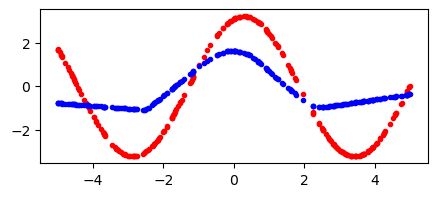

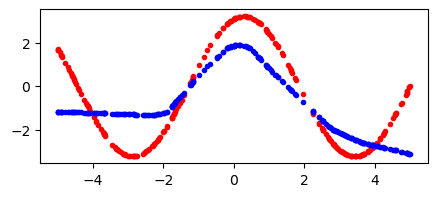

In [3]:
class Network(nn.Module):
    @nn.compact
    def __call__(self, x: np.ndarray) -> np.ndarray:
        x = nn.Dense(features=40)(x)
        x = nn.relu(x)
        x = nn.Dense(features=40)(x)
        x = nn.relu(x)
        x = nn.Dense(features=1)(x)
        return x

class TrainState(flax.struct.PyTreeNode):
    params: Any
    opt: Any = flax.struct.field(pytree_node=False)
    opt_state: Any
    module: Any = flax.struct.field(pytree_node=False)

@jax.jit
def update_fn(train_state, x, y):
    def loss_fn(grad_params):
        pred = train_state.module.apply(grad_params, x)
        return jnp.mean(jnp.square(pred - y))

    l, g = jax.value_and_grad(loss_fn)(train_state.params)
    updates, opt_state = train_state.opt.update(g, train_state.opt_state)
    params = optax.apply_updates(train_state.params, updates)
    train_state = train_state.replace(params=params, opt_state=opt_state)
    return train_state, {'loss': l}

network = Network()
params = network.init(jax.random.PRNGKey(0), jnp.zeros((1, 1)))
opt = optax.adam(learning_rate=0.001)
train_state = TrainState(params=params, opt=opt, opt_state=opt.init(params), module=network)

for i in range(1000):
    x_all, y_all, _, _ = generate_sinusoids(256, 1)
    x = x_all[:, 0]
    y = y_all[:, 0]
    train_state, info = update_fn(train_state, x, y)
    if i % 100 == 0:
        print(f"Loss: {info['loss']}")

import matplotlib.pyplot as plt

x_test, y_test, _, _ = generate_sinusoids(1, 256)
y_pred = train_state.module.apply(train_state.params, x_test)
plt.figure(figsize=(5, 2))
plt.plot(x_test[0], y_test[0], 'r.')
plt.plot(x_test[0], y_pred[0], 'b.')
plt.show()

for i in range(10):
    train_state, info = update_fn(train_state, x_test[0], y_test[0])
y_pred = train_state.module.apply(train_state.params, x_test)
plt.figure(figsize=(5, 2))
plt.plot(x_test[0], y_test[0], 'r.')
plt.plot(x_test[0], y_pred[0], 'b.')
plt.show()







Loss: 5.46851110458374
Loss: 1.0210866928100586
Loss: 0.8288792371749878
Loss: 0.3317016661167145
Loss: 0.15437760949134827
Loss: 0.24726560711860657
Loss: 0.17376205325126648
Loss: 0.10168447345495224
Loss: 0.13497838377952576
Loss: 0.11652107536792755


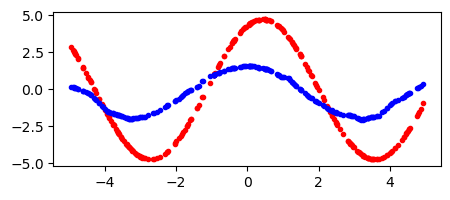

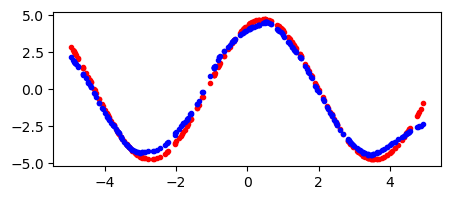

In [7]:
class Network(nn.Module):
    @nn.compact
    def __call__(self, x: np.ndarray) -> np.ndarray:
        x = nn.Dense(features=40)(x)
        x = nn.relu(x)
        x = nn.Dense(features=40)(x)
        x = nn.relu(x)
        x = nn.Dense(features=1)(x)
        return x

class TrainState(flax.struct.PyTreeNode):
    params: Any
    opt: Any = flax.struct.field(pytree_node=False)
    opt_state: Any
    module: Any = flax.struct.field(pytree_node=False)

@jax.jit
def update_fn(train_state, batch):
    train_x, train_y, val_x, val_y = batch # (32, 10, 1).
    inner_steps = 1

    # Take a step on (train_x, train_y) and evaluate on (val_x, val_y).
    def maml_loss(task_params, train_x, train_y, val_x, val_y):
        def task_loss(params, x, y):
            pred = train_state.module.apply(params, x)
            return jnp.mean(jnp.square(pred - y))
        for _ in range(inner_steps):
            model_grad = jax.grad(task_loss)(task_params, train_x, train_y)
            task_params = jax.tree_map(lambda p, g: p - 0.01 * g, task_params, model_grad)    
        loss = task_loss(task_params, val_x, val_y)
        # loss = task_loss(task_params, train_x, train_y)
        return loss

    def loss_fn(grad_params):
        maml_losses = jax.vmap(lambda task: maml_loss(grad_params, *task))(batch)
        return jnp.mean(maml_losses)

    l, g = jax.value_and_grad(loss_fn)(train_state.params)
    updates, opt_state = train_state.opt.update(g, train_state.opt_state)
    params = optax.apply_updates(train_state.params, updates)
    train_state = train_state.replace(params=params, opt_state=opt_state)
    return train_state, {'loss': l}

network = Network()
params = network.init(jax.random.PRNGKey(0), jnp.zeros((1, 1)))
opt = optax.adam(learning_rate=0.001)
train_state = TrainState(params=params, opt=opt, opt_state=opt.init(params), module=network)

for i in range(10000):
    batch = generate_sin_tasks(16, 64) # 32 tasks, each with 10 points.
    train_state, info = update_fn(train_state, batch)
    if i % 1000 == 0:
        print(f"Loss: {info['loss']}")

# import matplotlib.pyplot as plt

x_test, y_test, _, _ = generate_sinusoids(1, 256)
y_pred = train_state.module.apply(train_state.params, x_test)
plt.figure(figsize=(5, 2))
plt.plot(x_test[0], y_test[0], 'r.')
plt.plot(x_test[0], y_pred[0], 'b.')
plt.show()

def update_task(train_state, x, y):
    def loss_fn(params):
        pred = train_state.module.apply(params, x)
        return jnp.mean(jnp.square(pred - y))
    l, g = jax.value_and_grad(loss_fn)(train_state.params)
    params = jax.tree_map(lambda p, g: p - 0.01 * g, train_state.params, g)
    return train_state.replace(params=params)

for i in range(1):
    train_state = update_task(train_state, x_test[0], y_test[0])
y_pred = train_state.module.apply(train_state.params, x_test)
plt.figure(figsize=(5, 2))
plt.plot(x_test[0], y_test[0], 'r.')
plt.plot(x_test[0], y_pred[0], 'b.')
plt.show()







Loss: 4.575788497924805
Loss: 2.93827486038208
Loss: 4.307023048400879
Loss: 3.9544687271118164
Loss: 3.4418129920959473
Loss: 3.96600341796875
Loss: 6.183892250061035
Loss: 3.514970302581787
Loss: 3.4003641605377197
Loss: 3.47127628326416


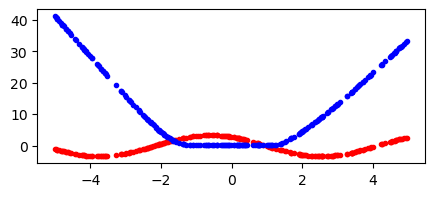

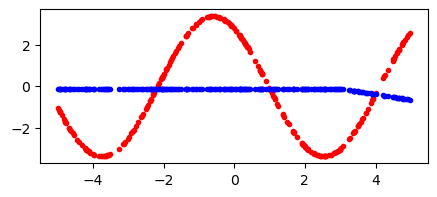

In [21]:
class Network(nn.Module):
    @nn.compact
    def __call__(self, x: np.ndarray) -> np.ndarray:
        x = nn.Dense(features=40)(x)
        x = nn.relu(x)
        x = nn.Dense(features=40)(x)
        x = nn.relu(x)
        x = nn.Dense(features=1)(x)
        return x

class TrainState(flax.struct.PyTreeNode):
    params: Any
    opt: Any = flax.struct.field(pytree_node=False)
    opt_state: Any
    module: Any = flax.struct.field(pytree_node=False)

@jax.jit
def update_fn(train_state, batch):
    inner_steps = 1

    # Take a step on (train_x, train_y) and evaluate on (val_x, val_y).
    def maml_grad(task_params, train_x, train_y, val_x, val_y):
        def task_loss(params, x, y):
            pred = train_state.module.apply(params, x)
            return jnp.mean(jnp.square(pred - y))
        for _ in range(inner_steps):
            model_grad = jax.grad(task_loss)(task_params, train_x, train_y)
            task_params = jax.tree_map(lambda p, g: p - 0.01 * g, task_params, model_grad)
        loss, grads = jax.value_and_grad(task_loss)(task_params, val_x, val_y)
        return loss, grads

    def grad_fn(grad_params):
        maml_grads = jax.vmap(lambda task: maml_grad(grad_params, *task))(batch)
        return jax.tree_map(lambda x: jnp.mean(x), maml_grads)

    l, g = grad_fn(train_state.params)
    # l, g = jax.value_and_grad(loss_fn)(train_state.params)
    updates, opt_state = train_state.opt.update(g, train_state.opt_state)
    params = optax.apply_updates(train_state.params, updates)
    train_state = train_state.replace(params=params, opt_state=opt_state)
    return train_state, {'loss': l}

network = Network()
params = network.init(jax.random.PRNGKey(0), jnp.zeros((1, 1)))
opt = optax.adam(learning_rate=0.001)
train_state = TrainState(params=params, opt=opt, opt_state=opt.init(params), module=network)

for i in range(10000):
    batch = generate_sin_tasks(16, 64) # 32 tasks, each with 10 points.
    train_state, info = update_fn(train_state, batch)
    if i % 1000 == 0:
        print(f"Loss: {info['loss']}")

# import matplotlib.pyplot as plt

x_test, y_test, _, _ = generate_sinusoids(1, 256)
y_pred = train_state.module.apply(train_state.params, x_test)
plt.figure(figsize=(5, 2))
plt.plot(x_test[0], y_test[0], 'r.')
plt.plot(x_test[0], y_pred[0], 'b.')
plt.show()

def update_task(train_state, x, y):
    def loss_fn(params):
        pred = train_state.module.apply(params, x)
        return jnp.mean(jnp.square(pred - y))
    l, g = jax.value_and_grad(loss_fn)(train_state.params)
    params = jax.tree_map(lambda p, g: p - 0.01 * g, train_state.params, g)
    return train_state.replace(params=params)

for i in range(1):
    train_state = update_task(train_state, x_test[0], y_test[0])
y_pred = train_state.module.apply(train_state.params, x_test)
plt.figure(figsize=(5, 2))
plt.plot(x_test[0], y_test[0], 'r.')
plt.plot(x_test[0], y_pred[0], 'b.')
plt.show()







(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
Loss: 4.677766799926758
Loss: 0.21721768379211426
Loss: 0.15262186527252197
Loss: 3.6318445205688477
Loss: 4.389043807983398
Loss: 0.030302435159683228
Loss: 0.011612843722105026
Loss: 0.31301450729370117
Loss: 0.059178270399570465
Loss: 0.05368846654891968


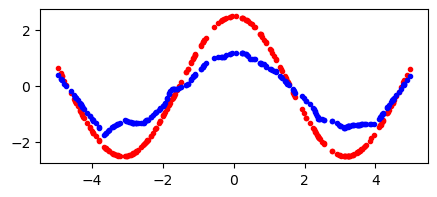

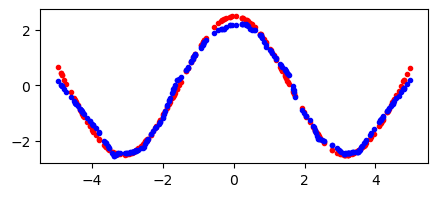

In [39]:
class Network(nn.Module):
    @nn.compact
    def __call__(self, x: np.ndarray) -> np.ndarray:
        x = nn.Dense(features=40)(x)
        x = nn.relu(x)
        x = nn.Dense(features=40)(x)
        x = nn.relu(x)
        x = nn.Dense(features=1)(x)
        return x

class TrainState(flax.struct.PyTreeNode):
    params: Any
    opt: Any = flax.struct.field(pytree_node=False)
    opt_state: Any
    module: Any = flax.struct.field(pytree_node=False)


inner_steps = 10
@jax.jit
def update_fn(train_state, batch):
    

    # Take a step on (train_x, train_y) and evaluate on (val_x, val_y).
    def maml_params(task_params, train_x, train_y):
        def task_loss(params, x, y):
            print(x.shape)
            pred = train_state.module.apply(params, x)
            return jnp.mean(jnp.square(pred - y))
        for i in range(inner_steps):
            inner_batchsize = train_x.shape[0] // inner_steps
            inner_x = train_x[i * inner_batchsize: (i + 1) * inner_batchsize]
            inner_y = train_y[i * inner_batchsize: (i + 1) * inner_batchsize]
            loss, model_grad = jax.value_and_grad(task_loss)(task_params, inner_x, inner_y)
            task_params = jax.tree_map(lambda p, g: p - 0.01 * g, task_params, model_grad)
        
        return loss, task_params

    train_x, train_y, val_x, val_y = batch # (32, 10, 1).
    l, mp = maml_params(train_state.params, train_x[0], train_y[0])
    stepsize = 0.1 # In paper, this number is annealed to zero.
    params = jax.tree_map(lambda p, m: p * (1-stepsize) + m * (stepsize), train_state.params, mp) 
    train_state = train_state.replace(params=params)
    return train_state, {'loss': l}

network = Network()
params = network.init(jax.random.PRNGKey(0), jnp.zeros((1, 1)))
opt = optax.adam(learning_rate=0.001)
train_state = TrainState(params=params, opt=opt, opt_state=opt.init(params), module=network)

for i in range(10000):
    batch = generate_sin_tasks(1, 640) # 32 tasks, each with 10 points.
    train_state, info = update_fn(train_state, batch)
    if i % 1000 == 0:
        print(f"Loss: {info['loss']}")

# import matplotlib.pyplot as plt

x_test, y_test, _, _ = generate_sinusoids(1, 256)
y_pred = train_state.module.apply(train_state.params, x_test)
plt.figure(figsize=(5, 2))
plt.plot(x_test[0], y_test[0], 'r.')
plt.plot(x_test[0], y_pred[0], 'b.')
plt.show()

def update_task(train_state, x, y):
    def loss_fn(params):
        pred = train_state.module.apply(params, x)
        return jnp.mean(jnp.square(pred - y))
    l, g = jax.value_and_grad(loss_fn)(train_state.params)
    params = jax.tree_map(lambda p, g: p - 0.01 * g, train_state.params, g)
    return train_state.replace(params=params)

for i in range(5):
    train_state = update_task(train_state, x_test[0], y_test[0])
y_pred = train_state.module.apply(train_state.params, x_test)
plt.figure(figsize=(5, 2))
plt.plot(x_test[0], y_test[0], 'r.')
plt.plot(x_test[0], y_pred[0], 'b.')
plt.show()





